In [1]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
import warnings, os
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm


warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
from aggmap import show

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc


def score(dfr):
    y_true = dfr.y_true
    y_score = dfr.y_score
    y_pred = dfr.y_score.round()

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    acc = (tp + tn) / sum([tn, fp, fn, tp])
    auc = roc_auc_score(y_true, y_score)

    print('acc: %.3f, roc-auc: %.3f' % (acc,auc))

    return acc, auc

def CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False):
    '''
    Forward prop. Feature importance
    '''
    
    if task_type == 'classification':
        f = log_loss
    else:
        f = mean_squared_error
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    grid = mp.plot_grid()
    Y_true = dfY.values
    df_grid = mp.df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y_prob = model.predict(arrX)
    N, W, H, C = arrX.shape
    
    if (sigmoidy) & (task_type == 'classification'):
        Y_prob = sigmoid(Y_prob)

    final_res = {}
    for k, col in enumerate(dfY.columns):
        
        if col == 'Healthy':
            continue
            
        print('calculating feature importance for %s ...' % col)
        
        results = []
        loss = f(Y_true[:, k].tolist(), Y_prob[:, k].tolist())
        for i in tqdm(range(len(df_grid)), ascii= True):
            ts = df_grid.iloc[i]
            y = ts.y
            x = ts.x
            X1 = copy(arrX)
            X1[:, y, x,:] = np.full(X1[:, y, x,:].shape, fill_value = arrX.min())
            #Y1 = model.predict(X1)
            Y_pred_prob = model.predict(X1)
            if (sigmoidy) & (task_type == 'classification'):
                Y_pred_prob = sigmoid(Y_pred_prob)
            mut_loss = f(Y_true[:, k].tolist(), Y_pred_prob[:, k].tolist()) 
            res =  mut_loss - loss # if res > 0, important, othervise, not important
            results.append(res)
            
        final_res.update({col:results})
    df = pd.DataFrame(final_res)
    df.columns = df.columns + '_importance'
    df = df_grid.join(df)
    return df

In [3]:
label = pd.read_excel('./data/subject_info.xlsx', index_col = 'Subject_ID')
data = pd.read_excel('./data/data_species_7278_preprocessed.xlsx', index_col = 0)
mp = loadmap('./CRC_stage.mp')

In [6]:
stage = 'Stage_III_IV'
model_dir = './%s_model' % stage

sld = label[label.Group.isin(['Healthy', stage])].index
dfy = label.loc[sld][['Group']]
dfx = data.loc[sld]
dfx = np.log(dfx + 1e-8)
dfy.shape, dfx.shape


X = mp.batch_transform(dfx.values, scale_method = 'standard', fillnan = np.log(1e-8))
Y = pd.get_dummies(dfy['Group']).values

class_ = pd.get_dummies(dfy['Group']).columns
class_


100%|##########| 181/181 [00:35<00:00,  5.14it/s]


Index(['Healthy', 'Stage_III_IV'], dtype='object')

In [7]:
outer_fold = 10
repeat_seed = 8

outer = StratifiedKFold(n_splits = outer_fold, shuffle = True, random_state = repeat_seed)
outer_idx = outer.split(X, Y[:,0])

run_one_res = []
for i, idx in enumerate(outer_idx):

    fold_num = "fold_%s" % str(i).zfill(2) 

    train_idx, test_idx = idx

    testY = Y[test_idx]
    testX = X[test_idx]

    trainX = X[train_idx]
    trainY = Y[train_idx]
    
    model_name = os.path.join('./%s' % model_dir, 'seed_%s_fold_%s.h5' % (repeat_seed, i))
    
    print("\n input train and test X shape is %s, %s " % (trainX.shape,  testX.shape))

    ## load model
    model = load_model(model_name)

    arrX = trainX
    dfY = pd.DataFrame(trainY, columns = pd.get_dummies(dfy['Group']).columns)

    df_imp = CalcFeatImp(model, mp, arrX, dfY, task_type = 'classification', sigmoidy = False)

    run_one_res.append(df_imp)



 input train and test X shape is (162, 86, 85, 5), (19, 86, 85, 5) 
2021-01-11 12:47:41,274 - INFO - [bidd-aggmap] - generate file: ./feature points_7278_correlation_umap_mp
2021-01-11 12:47:41,459 - INFO - [bidd-aggmap] - save html file to ./feature points_7278_correlation_umap_mp


  0%|          | 0/7310 [00:00<?, ?it/s]

calculating feature importance for Stage_III_IV ...


100%|##########| 7310/7310 [29:13<00:00,  4.17it/s]  



 input train and test X shape is (163, 86, 85, 5), (18, 86, 85, 5) 
2021-01-11 13:17:00,528 - INFO - [bidd-aggmap] - generate file: ./feature points_7278_correlation_umap_mp
2021-01-11 13:17:00,700 - INFO - [bidd-aggmap] - save html file to ./feature points_7278_correlation_umap_mp


  0%|          | 1/7310 [00:00<23:31,  5.18it/s]

calculating feature importance for Stage_III_IV ...


 28%|##7       | 2039/7310 [07:02<16:34,  5.30it/s]  

KeyboardInterrupt: 

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

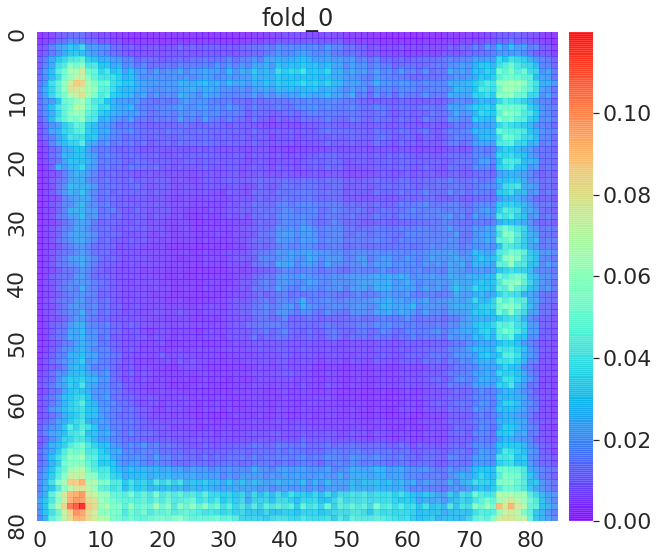

In [8]:
## plot each fold
impname = '%s_importance' % stage
for i, dfi in enumerate(run_one_res):    
    
    sns.set(style='white',  font='sans-serif', font_scale=2)
    fig, ax  = plt.subplots(1, 1, figsize=(10, 9))
    
    fold = 'fold_%s' % i
    
    IMPM = dfi[impname].values.reshape(*mp.fmap_shape)
    sns.heatmap(IMPM,  
                cmap = 'rainbow', alpha = 0.8, xticklabels=10, ax =ax,
                yticklabels=10, vmin = 0,
                cbar_kws = {'fraction':0.046, 'pad':0.02})

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.title(fold)

    plt.subplots_adjust(wspace = 0.18)

    plt.savefig('./%s/%s.svg' % (model_dir, fold), dpi = 400, bbox_inches="tight")
    

## save feature importance xlsx
fda = pd.concat(run_one_res, axis=1)[impname]
fda.columns = ['fold_%s_importance' % i for i in range(outer_fold)]
df1 = run_one_res[0]
df1 = df1[['x', 'y', 'v', 'Subtypes', 'colors', ]]
df1['%s_mean' % impname] = pd.concat(run_one_res, axis=1)[impname].mean(axis=1)
df1 = df1.join(fda)
df1 = df1.sort_values('%s_mean' % impname, ascending = False)
df1.to_excel('./results/importance_%s.xlsx' % stage)


## plot fold average
sns.set(style='white',  font='sans-serif', font_scale=2)
fig, ax  = plt.subplots(1, 1, figsize=(10, 9))
fold = stage
dfi = run_one_res[0]
dfi = dfi[['x', 'y', 'v', 'Subtypes', 'colors', ]]
dfi['%s_mean' % impname] = pd.concat(run_one_res, axis=1)[impname].mean(axis=1)

IMPM = dfi['%s_mean' % impname].values.reshape(*mp.fmap_shape)
sns.heatmap(IMPM,  
            cmap = 'rainbow', alpha = 0.8, xticklabels=10, ax =ax,
            yticklabels=10, vmin = 0,
            cbar_kws = {'fraction':0.046, 'pad':0.02})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title(fold)

plt.subplots_adjust(wspace = 0.18)

plt.savefig('./%s/fold_avg.svg' % (model_dir), dpi = 400, bbox_inches="tight")